In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
movies = pd.read_csv("movies.csv")
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [22]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

[Text(0.5, 1.0, 'distribution of rating')]

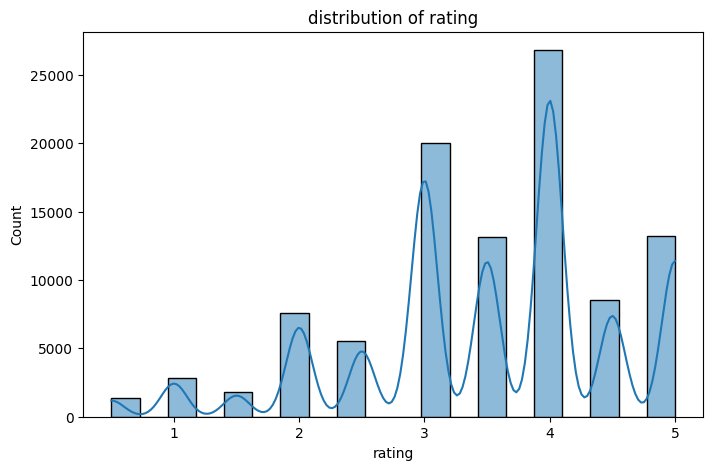

In [23]:
data = pd.read_csv("ratings.csv")
data.drop(columns = ['timestamp'],inplace = True)
plt.figure(figsize=(8,5))
sns.histplot(x=data['rating'],bins=20,kde=True).set(title='distribution of rating')

In [24]:
data['rating'] = data['rating'].apply(lambda x: 1 if x >= 4 else 0)
data

,userId,movieId,rating
0,1,1,1
1,1,3,1
2,1,6,1
3,1,47,1
4,1,50,1
...,...,...,...
100831,610,166534,1
100832,610,168248,1
100833,610,168250,1
100834,610,168252,1


In [25]:
data.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

[Text(0.5, 1.0, 'distribution of rating after tranformation')]

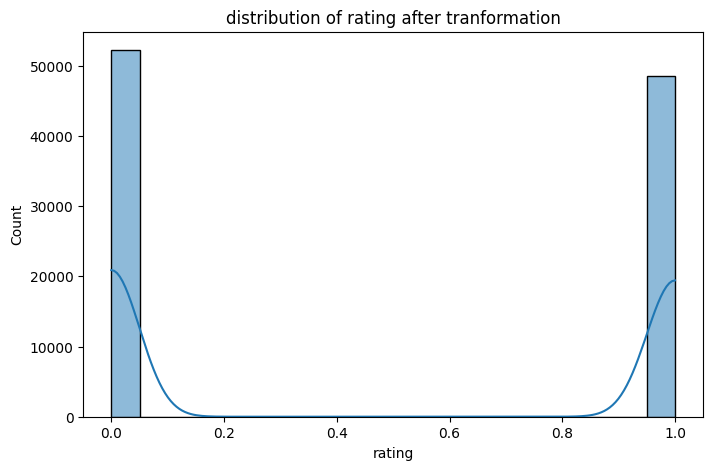

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(x=data['rating'],bins=20,kde=True).set(title='distribution of rating after tranformation')

# One Hot Encoding

In [27]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
          'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_df = pd.DataFrame(columns=genres, index=movies.index)
genre_df = genre_df.fillna(0)

# Iterate through each movie and set the binary genre indicators
for i, row in movies.iterrows():
    movie_genres = [g.strip() for g in str(row['genres']).split('|')]
    for genre in genres:
        if genre in movie_genres:
            genre_df.at[i, genre] = 1

# Combine the original movies DataFrame with the new genre DataFrame
movies_with_genres = pd.concat([movies, genre_df], axis=1)
movies_with_genres.drop(columns = ['title','genres'], inplace = True)

In [28]:
merged_df = pd.merge(data, movies_with_genres, left_on='movieId', right_on='movieId',how='left')
merged_df

,userId,movieId,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,1,0,1,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,3,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
100832,610,168248,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
100834,610,168252,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Training Model for each user

In [29]:
from sklearn.linear_model import LogisticRegression

model_of_each_user = {}

for x,y in merged_df.groupby('userId'):
    if(y['rating'].nunique() == 1):
        print("This user has done high rating to all movies :", x)
        continue
    X_train = y.drop(columns = ['userId','movieId','rating'])
    y_train = y['rating']
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    model_of_each_user[x] = model

This user has done high rating to all movies : 25
This user has done high rating to all movies : 49
This user has done high rating to all movies : 53
This user has done high rating to all movies : 442
This user has done high rating to all movies : 515


# Recommending Movie to User

In [30]:
def recommend_movie_to_userLR(userId,movies_with_genres,model_of_each_user,moviesTorecommend = 10):
    temp = data.loc[data['userId'] == userId]
    prob_of_movies = []
    id_of_movies = []
    for index1,row1 in movies_with_genres.iterrows():
        X_test = [row1['Action'],row1['Adventure'],row1['Animation'],row1['Children'],row1['Comedy']
                            ,row1['Crime'],row1['Documentary'],row1['Drama'],row1['Fantasy'],row1['Film-Noir']
                            ,row1['Horror'],row1['Musical'],row1['Mystery'],row1['Romance'],row1['Sci-Fi'],row1['Thriller']
                            ,row1['War'],row1['Western']]
        X_test = np.array(X_test)
        X_test = X_test.reshape(-1,X_test.shape[0])
        
        model = model_of_each_user[userId]
        
        prob_of_movies.append(model.predict_proba(X_test)[:, 1])
        id_of_movies.append(row1['movieId'])
    zipped = zip(id_of_movies,prob_of_movies)

    sorted_probs = sorted(zipped, key=lambda x: x[1], reverse=True)
    list_recommendation = []
    for x,y in sorted_probs:
        if len(temp.loc[temp['movieId']==x]) == 0:
            list_recommendation.append(x)
        if len(list_recommendation) >= moviesTorecommend:
            break
    
    return list_recommendation

In [35]:
def fromidtoname(list_of_movie):
    movies_name = []
    for x in list_of_movie:
        movie_info = movies.loc[movies['movieId'] == x]
        movies_name.append(movie_info['title'])
    return movies_name

In [36]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

list_of_movies = recommend_movie_to_userLR(1,movies_with_genres,model_of_each_user)

In [37]:
fromidtoname(list_of_movies)

[1390    Mulan (1998)
 Name: title, dtype: object,
 2530    Shanghai Surprise (1986)
 Name: title, dtype: object,
 9381    Your Name. (2016)
 Name: title, dtype: object,
 5248    Tokyo Godfathers (2003)
 Name: title, dtype: object,
 7327    Sky Crawlers, The (Sukai kurora) (2008)
 Name: title, dtype: object,
 9387    Over the Garden Wall (2013)
 Name: title, dtype: object,
 4530    Millennium Actress (Sennen joyû) (2001)
 Name: title, dtype: object,
 5596    Whisper of the Heart (Mimi wo sumaseba) (1995)
 Name: title, dtype: object,
 6931    5 Centimeters per Second (Byôsoku 5 senchimêto...
 Name: title, dtype: object,
 8047    From Up on Poppy Hill (Kokuriko-zaka kara) (2011)
 Name: title, dtype: object]